Dataset Loaded: 5600 files


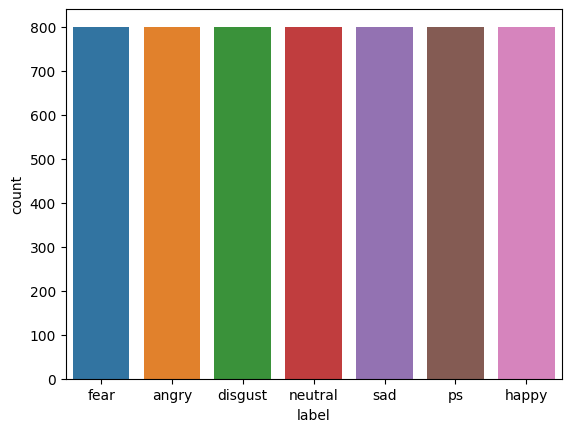

Feature shape: (5600, 100, 40)
Training samples: 4480 | Validation samples: 1120


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 256)                 │         173,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 190,983 (746.03 KB)

 Trainable params: 190,471 (744.03 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.6262 - loss: 1.0876 - val_accuracy: 0.8152 - val_loss: 0.8473 - learning_rate: 0.0010
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - accuracy: 0.9818 - loss: 0.0752 - val_accuracy: 0.9839 - val_loss: 0.3220 - learning_rate: 0.0010
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.9853 - loss: 0.0481 - val_accuracy: 0.9937 - val_loss: 0.1123 - learning_rate: 0.0010
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.9946 - loss: 0.0179 - val_accuracy: 0.9884 - val_loss: 0.0665 - learning_rate: 0.0010
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 0.9964 - loss: 0.0145 - val_accuracy: 0.9955 - val_loss: 0.0218 - learning_rate: 0.0010
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.9980 - loss: 0.0058 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - accuracy: 0.9990 - loss: 0.

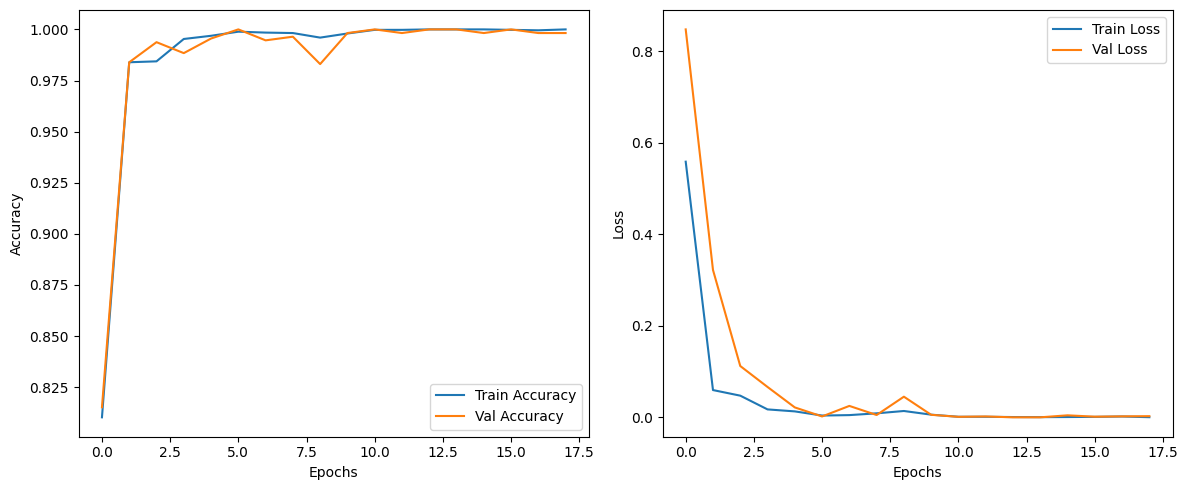

Best Training Accuracy: 100.00%
Best Validation Accuracy: 100.00%


In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings('ignore')

# -----------------------------
# 1. Load dataset and create DataFrame
# -----------------------------
paths = []
labels = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        # Assuming the emotion label is at the end of the filename separated by an underscore
        label = filename.split('_')[-1].split('.')[0].lower()
        labels.append(label)
print('Dataset Loaded:', len(paths), 'files')

df = pd.DataFrame({'speech': paths, 'label': labels})
sns.countplot(x=df['label'])
plt.show()

# -----------------------------
# 2. Improved MFCC Feature Extraction Function
# -----------------------------
def extract_mfcc_features(filename, n_mfcc=40, max_len=100):
    """
    Loads an audio file and extracts a fixed-length MFCC feature matrix.
    - n_mfcc: number of MFCCs to extract.
    - max_len: number of time frames to pad/truncate to.
    """
    y, sr = librosa.load(filename, sr=None)
    
    # Optional: Data augmentation example (uncomment to use)
    # y = librosa.effects.pitch_shift(y, sr, n_steps=2)  
    # y = librosa.effects.time_stretch(y, rate=1.1)
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # Pad or truncate to ensure fixed number of frames
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    # Normalize MFCC
    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
    # Transpose to shape: (time_steps, n_mfcc)
    return mfcc.T

# Extract features for all audio files
n_mfcc = 40
max_len = 100  # Adjust based on your audio duration characteristics
features = df['speech'].apply(lambda x: extract_mfcc_features(x, n_mfcc=n_mfcc, max_len=max_len))
X = np.array(list(features))  # Shape: (num_samples, max_len, n_mfcc)
print("Feature shape:", X.shape)

# -----------------------------
# 3. Encode labels and split data
# -----------------------------
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']]).toarray()

# Use an explicit train/validation split for reproducibility
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0], "| Validation samples:", X_val.shape[0])

# -----------------------------
# 4. Define the LSTM Model (with Bidirectional LSTM)
# -----------------------------
num_classes = y.shape[1]
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=False), input_shape=(max_len, n_mfcc)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# -----------------------------
# 5. Train the Model with Callbacks
# -----------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=50, batch_size=64, callbacks=callbacks, shuffle=True)

# -----------------------------
# 6. Plot Training History
# -----------------------------
epochs_range = range(len(history.history['accuracy']))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Display best metrics
best_train_acc = max(history.history['accuracy'])
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Training Accuracy: {best_train_acc * 100:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}%")
